# Random parameter scan

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator
from typing import Callable, Union
from concurrent import futures
from tqdm.notebook import tqdm
from functools import partial

import models


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def get_carbon_production(v: Union[dict[str, float], pd.DataFrame]):
    return (v["PGA_out"] + v["DHAP_out"] + v["GAP_out"]) * 3 + v["starch_production"] * 6


def plot_by_enzyme(m, p, df, name, n_cols=4):
    n_rows = math.ceil(len(parameters_to_scan) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), sharey=True)
    for ax, par in zip(axs.flatten(), p.columns):
        ax.plot(p[par], df[name], "o")
        ax.set(xlabel=par)
        ax.set_xscale("log")
        ax.axvline(m.get_parameter(par), color="grey", linestyle="dashed")
    fig.suptitle(f"Steady-state {name}", size=14)
    fig.tight_layout()
    plt.show()

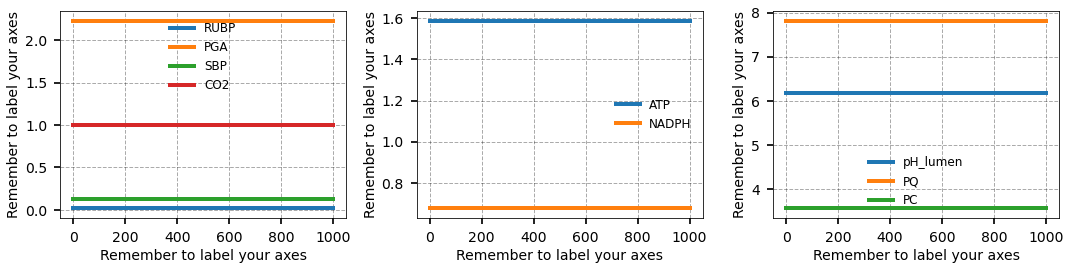

In [2]:
y0 = {
    "PGA": 2.22873434718272,
    "BPGA": 0.0011395172052077612,
    "GAP": 0.01437795470974676,
    "DHAP": 0.3163149207711214,
    "FBP": 0.03229051286383597,
    "F6P": 1.4343838296513272,
    "G6P": 3.2990828070597114,
    "G1P": 0.19134680278075727,
    "SBP": 0.1335411445953625,
    "S7P": 0.39001212495414045,
    "E4P": 0.03247522204994075,
    "X5P": 0.05334449596937869,
    "R5P": 0.08935202710233939,
    "RUBP": 0.01800248355473164,
    "RU5P": 0.035740810220277044,
    "ATP": 1.5874832946823467,
    "Fd": 1.8290228380069975,
    "H_lumen": 0.0025962760706543775,
    "LHC": 0.6898134477022976,
    "NADPH": 0.676312076692619,
    "PC": 3.5654905892778137,
    "PQ": 7.816317812545427,
    "Psbs": 0.9396093683259324,
    "Vx": 0.8977559186623475,
    "TR_ox": 0.7059742923625622,
    "E_inactive": 1.5227432839282888,
    "MDA": 0.00010516387564148172,
    "H2O2": 5.828488769494365e-05,
    "DHA": 2.7489043868278393e-06,
    "GSSG": 1.3335621272543244e-06,
    "GLY": 11.927538736093107,
    "GLYC": 0.01453827416297996,
    "GLYX": 0.21956585389678646,
    "HPA": 0.003014225861566207,
    "SER": 1.3081512964720516,
    "2PG": 3.7113656305615343e-06,
    "GLYA": 0.004954584293529081,
    "CO2": 1.0061496713328153,
    "HCO3": 50.30748356664077,
}

m = models.get_c3_mesophyll()

SHARED_PAR_UPDATES = {
    "pfd": 700,
    "O2": 0.1,
    "CO2_ext": 2,
    "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
}
m.update_parameters(SHARED_PAR_UPDATES)
# m.update_parameter("vmax_phosphoglycolate_phosphatase", 100)
s = Simulator(m)
s.initialise(y0)
t, y = s.simulate(1000)
s.plot_grid(
    [
        ["RUBP", "PGA", "SBP", "CO2"],
        ["ATP", "NADPH"],
        ["pH_lumen", "PQ", "PC"],
    ],
    sharey=False,
)
plt.show()

In [3]:
def plot_photorespiration(s):
    cpds = [
        "2PG",
        "GLYC",
        "GLYX",
        "GLY",
        "SER",
        "HPA",
        "H2O2",
        "GLYA",
    ]
    rates = [
        "rubisco_o2",
        "phosphoglycolate_phosphatase",
        "glycolate_oxidase",
        "glycine_transaminase",
        "glycine_decarboxylase",
        "serine_glyoxylate_transaminase",
        "glycerate_dehydrogenase",
        "glycerate_kinase",
        "catalase",
    ]
    s.plot_selection(cpds)
    s.plot_flux_selection(rates)


# plot_photorespiration(s)

In [4]:
def lognormal(center, scale, n_samples):
    return np.random.lognormal(np.log(center), scale, n_samples)


def _scan_worker(
    parameters: dict[str, float],
    *,
    model: Model,
    y0: dict[str, float],
    t_end=2 * 60 * 60,
):
    s = Simulator(model)
    s.initialise(y0)
    s.update_parameters(parameters)
    try:
        t, y = s.simulate(t_end)
    except:
        t = None
        y = None
    if t is None or y is None or np.linalg.norm(y[-1] - y[-2], 2) > 1e8:
        concentrations = dict(
            zip(m.get_all_compounds(), np.full(len(m.get_all_compounds()), np.NaN))
        )
        fluxes = dict(zip(m.get_rate_names(), np.full(len(m.get_rate_names()), np.NaN)))
    else:
        fluxes = dict(s.get_fluxes_df(concatenated=True).iloc[-1])
        concentrations = dict(s.get_full_results_df(concatenated=True).iloc[-1])
    return parameters, concentrations, fluxes


def parameter_scan(
    model: Model,
    y0: dict[str, float],
    parameter_names: list[str],
    scale: float,
    n_samples: int,
    distribution: Callable[[float, float, int], np.ndarray] = lognormal,
):
    parameter_values = np.array(
        [
            distribution(model.get_parameter(parameter_name), scale, n_samples)
            for parameter_name in parameter_names
        ],
    ).T

    worker = partial(_scan_worker, model=model, y0=y0)
    Executor = futures.ProcessPoolExecutor
    with tqdm(total=len(parameter_values)) as pbar:
        with Executor() as executor:
            results = []
            for task in futures.as_completed(
                (
                    executor.submit(worker, dict(zip(parameter_names, i)))
                    for i in parameter_values
                )
            ):
                results.append(task.result())
                pbar.update(1)
    p = pd.DataFrame(i[0] for i in results)
    c = pd.DataFrame(i[1] for i in results)
    v = pd.DataFrame(i[2] for i in results)
    return p, c, v

## Matuszynska

In [5]:
y0_no_pr = {
    "PGA": 2.22873434718272,
    "BPGA": 0.0011395172052077612,
    "GAP": 0.01437795470974676,
    "DHAP": 0.3163149207711214,
    "FBP": 0.03229051286383597,
    "F6P": 1.4343838296513272,
    "G6P": 3.2990828070597114,
    "G1P": 0.19134680278075727,
    "SBP": 0.1335411445953625,
    "S7P": 0.39001212495414045,
    "E4P": 0.03247522204994075,
    "X5P": 0.05334449596937869,
    "R5P": 0.08935202710233939,
    "RUBP": 0.01800248355473164,
    "RU5P": 0.035740810220277044,
    "ATP": 1.5874832946823467,
    "Fd": 1.8290228380069975,
    "H_lumen": 0.0025962760706543775,
    "LHC": 0.6898134477022976,
    "NADPH": 0.676312076692619,
    "PC": 3.5654905892778137,
    "PQ": 7.816317812545427,
    "Psbs": 0.9396093683259324,
    "Vx": 0.8977559186623475,
    "TR_ox": 0.7059742923625622,
    "E_inactive": 1.5227432839282888,
    "MDA": 0.00010516387564148172,
    "H2O2": 5.828488769494365e-05,
    "DHA": 2.7489043868278393e-06,
    "GSSG": 1.3335621272543244e-06,
    "GLY": 11.927538736093107,
    "GLYC": 0.01453827416297996,
    "GLYX": 0.21956585389678646,
    "HPA": 0.003014225861566207,
    "SER": 1.3081512964720516,
    "2PG": 3.7113656305615343e-06,
    "GLYA": 0.004954584293529081,
    "CO2": 1.0061496713328153,
    "HCO3": 50.30748356664077,
}

parameters_to_scan = [
    "kATPsynth",
    "kCytb6f",
    "kcyc",
    "kNDH",
    "kPTOX",
]


pm, cm, vm = parameter_scan(
    model=m,
    y0=y0_no_pr,
    parameter_names=parameters_to_scan,
    scale=1,
    n_samples=100,
)

cm_rel = cm / cm.mean()
vm_rel = vm / vm.mean()

print(f"{sum(cm.iloc[:, 0].isna() / len(cm)):.1%} failed attempts")

  0%|          | 0/100 [00:00<?, ?it/s]

0.0% failed attempts


In [6]:
std = cm_rel.describe().loc["std"].sort_values(ascending=False)
print(std[:5])
# ax = c.describe().loc["std"].plot(title="Concentrations std")
for i in std.index[:3]:
    plot_by_enzyme(m, pm, cm_rel, i)

Keq_ATPsynthase    6.366422
DHA                5.040378
GSSG               5.026560
A1                 2.531737
MDA                2.167690
Name: std, dtype: float64


CO2_hydration    7.176101
vGR              5.021118
vDHAR            5.016042
v3ASC            5.004640
vMehler          2.531737
Name: std, dtype: float64


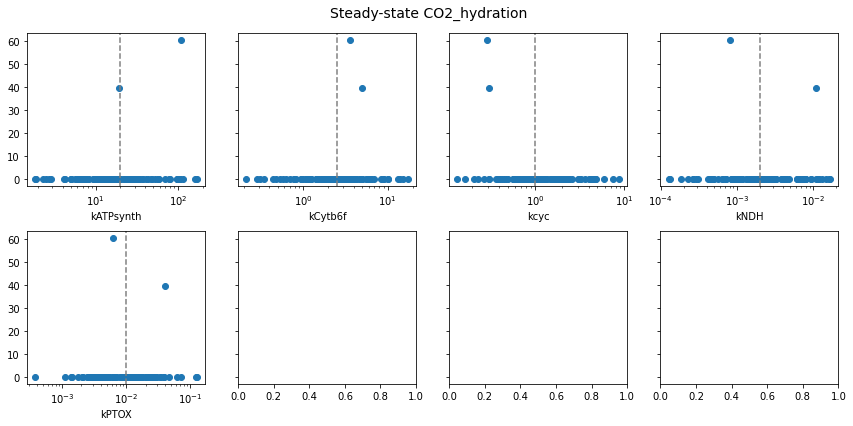

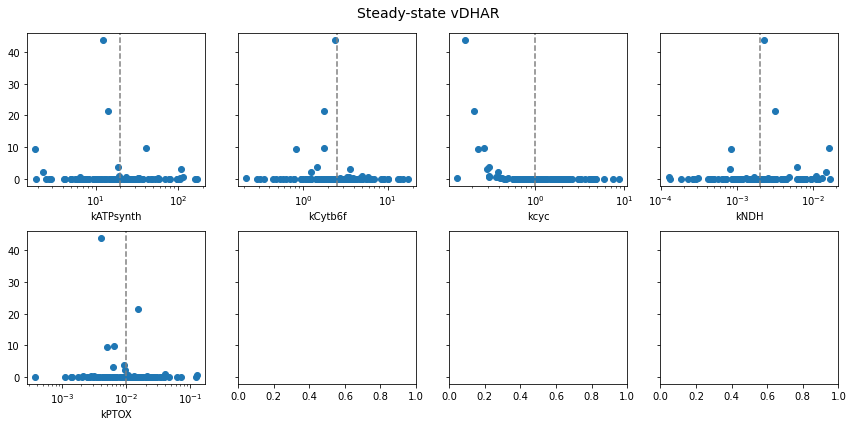

In [7]:
std = vm_rel.describe().loc["std"].sort_values(ascending=False)
print(std[:5])
# ax = std.plot(title="Fluxes std")
for i in std.index[:3]:
    plot_by_enzyme(m, pm, vm_rel, i)

## Poolman

In [8]:
y0_no_pr = {
    "PGA": 2.22873434718272,
    "BPGA": 0.0011395172052077612,
    "GAP": 0.01437795470974676,
    "DHAP": 0.3163149207711214,
    "FBP": 0.03229051286383597,
    "F6P": 1.4343838296513272,
    "G6P": 3.2990828070597114,
    "G1P": 0.19134680278075727,
    "SBP": 0.1335411445953625,
    "S7P": 0.39001212495414045,
    "E4P": 0.03247522204994075,
    "X5P": 0.05334449596937869,
    "R5P": 0.08935202710233939,
    "RUBP": 0.01800248355473164,
    "RU5P": 0.035740810220277044,
    "ATP": 1.5874832946823467,
    "Fd": 1.8290228380069975,
    "H_lumen": 0.0025962760706543775,
    "LHC": 0.6898134477022976,
    "NADPH": 0.676312076692619,
    "PC": 3.5654905892778137,
    "PQ": 7.816317812545427,
    "Psbs": 0.9396093683259324,
    "Vx": 0.8977559186623475,
    "TR_ox": 0.7059742923625622,
    "E_inactive": 1.5227432839282888,
    "MDA": 0.00010516387564148172,
    "H2O2": 5.828488769494365e-05,
    "DHA": 2.7489043868278393e-06,
    "GSSG": 1.3335621272543244e-06,
    "GLY": 11.927538736093107,
    "GLYC": 0.01453827416297996,
    "GLYX": 0.21956585389678646,
    "HPA": 0.003014225861566207,
    "SER": 1.3081512964720516,
    "2PG": 3.7113656305615343e-06,
    "GLYA": 0.004954584293529081,
    "CO2": 1.0061496713328153,
    "HCO3": 50.30748356664077,
}

parameters_to_scan = [
    "Vmax_rubisco_co2",
    "Vmax_rubisco_o2",
    "Vmax_6",
    "Vmax_9",
    "Vmax_13",
    "Vmax_starch",
    "Vmax_efflux",
]


pp, cp, vp = parameter_scan(
    model=m,
    y0=y0_no_pr,
    parameter_names=parameters_to_scan,
    scale=1,
    n_samples=100,
)

cp_rel = cp / cp.mean()
vp_rel = vp / vp.mean()

print(f"{sum(cp.iloc[:, 0].isna() / len(cp)):.1%} failed attempts")

  0%|          | 0/100 [00:00<?, ?it/s]

13.0% failed attempts


DHA                4.329013
GSSG               4.309935
SBP                3.115721
FBP                2.924772
Keq_ATPsynthase    2.847451
Name: std, dtype: float64


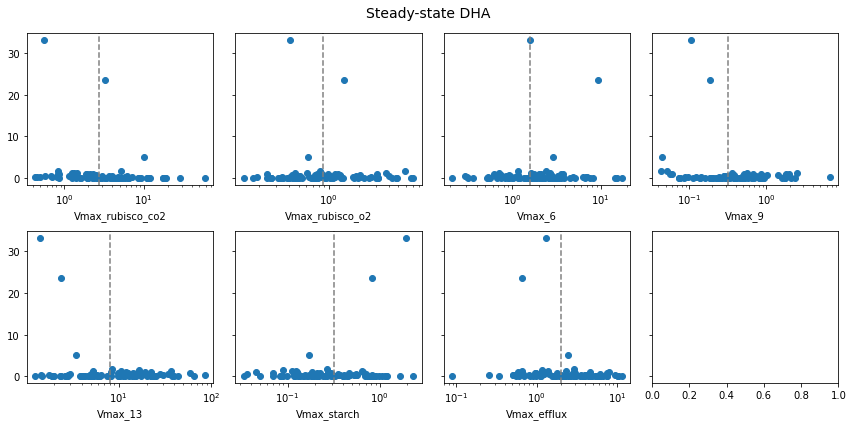

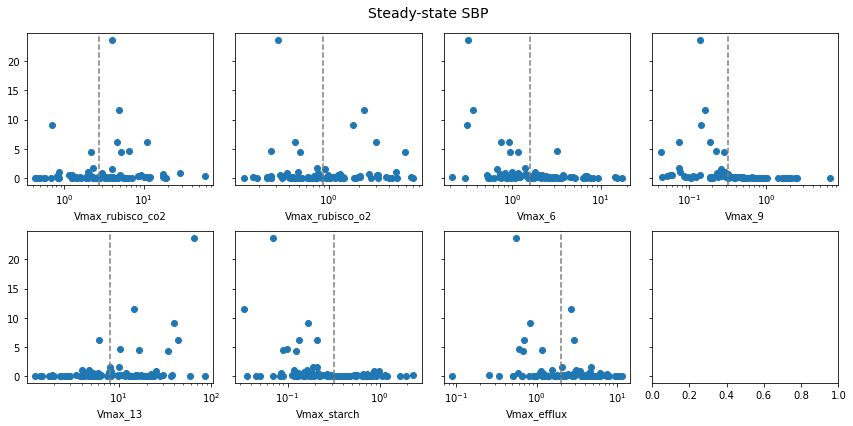

In [9]:
std = cp_rel.describe().loc["std"].sort_values(ascending=False)
print(std[:5])
# ax = c.describe().loc["std"].plot(title="Concentrations std")
for i in std.index[:3]:
    plot_by_enzyme(m, pp, cp_rel, i)

vGR              4.304979
vDHAR            4.304979
v3ASC            4.304978
CO2_hydration    2.435346
vMehler          2.276158
Name: std, dtype: float64


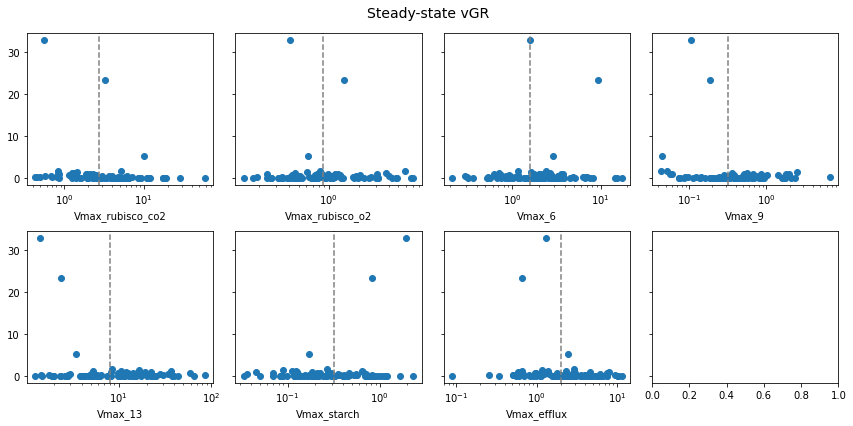

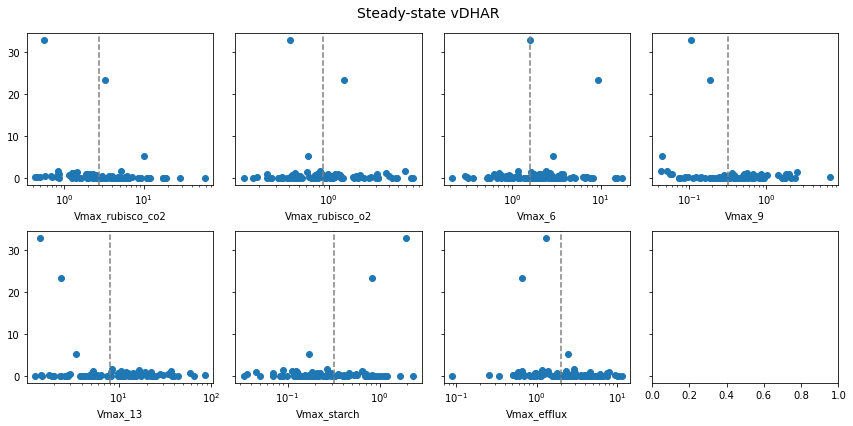

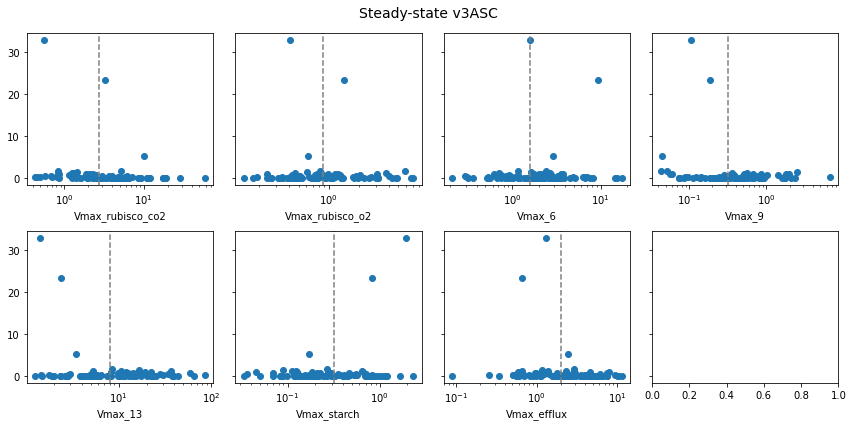

In [10]:
std = vp_rel.describe().loc["std"].sort_values(ascending=False)
print(std[:5])
# ax = std.plot(title="Fluxes std")
for i in std.index[:3]:
    plot_by_enzyme(m, pp, vp_rel, i)

## Yokota

In [11]:
y0_no_pr = {
    "PGA": 2.22873434718272,
    "BPGA": 0.0011395172052077612,
    "GAP": 0.01437795470974676,
    "DHAP": 0.3163149207711214,
    "FBP": 0.03229051286383597,
    "F6P": 1.4343838296513272,
    "G6P": 3.2990828070597114,
    "G1P": 0.19134680278075727,
    "SBP": 0.1335411445953625,
    "S7P": 0.39001212495414045,
    "E4P": 0.03247522204994075,
    "X5P": 0.05334449596937869,
    "R5P": 0.08935202710233939,
    "RUBP": 0.01800248355473164,
    "RU5P": 0.035740810220277044,
    "ATP": 1.5874832946823467,
    "Fd": 1.8290228380069975,
    "H_lumen": 0.0025962760706543775,
    "LHC": 0.6898134477022976,
    "NADPH": 0.676312076692619,
    "PC": 3.5654905892778137,
    "PQ": 7.816317812545427,
    "Psbs": 0.9396093683259324,
    "Vx": 0.8977559186623475,
    "TR_ox": 0.7059742923625622,
    "E_inactive": 1.5227432839282888,
    "MDA": 0.00010516387564148172,
    "H2O2": 0,
    "DHA": 2.7489043868278393e-06,
    "GSSG": 1.3335621272543244e-06,
    "GLY": 0,
    "GLYC": 0,
    "GLYX": 0,
    "HPA": 0,
    "SER": 0,
    "2PG": 0,
    "GLYA": 0,
    "CO2": 1.0061496713328153,
    "HCO3": 50.30748356664077,
}

parameters_to_scan = [
    "vmax_phosphoglycolate_phosphatase",  # 2PG -> GLYC
    "vmax_glycolate_oxidase",  # GLYC -> GLYX
    "vmax_glycine_transaminase",  # GLYX -> GLY
    "vmax_glycine_decarboxylase",  # GLY -> SER
    "vmax_ser_gly_transaminase",  # GLYX + SER -> GLY + HPA
    "vmax_glycerate_dehydrogenase",  # HPA -> GLYA
    "vmax_glycerate_kinase",  # GLYA -> PGA
    "vmax_catalase",
]


py, cy, vy = parameter_scan(
    model=m,
    y0=y0_no_pr,
    parameter_names=parameters_to_scan,
    scale=1,
    n_samples=100,
)

cy_rel = cy / cy.mean()
vy_rel = vy / vy.mean()

print(f"{sum(cy.iloc[:, 0].isna() / len(cy)):.1%} failed attempts")

  0%|          | 0/100 [00:00<?, ?it/s]

0.0% failed attempts


GLYC    5.918508
GLYX    2.474115
HPA     1.664149
SER     1.489425
GLYA    1.459298
Name: std, dtype: float64


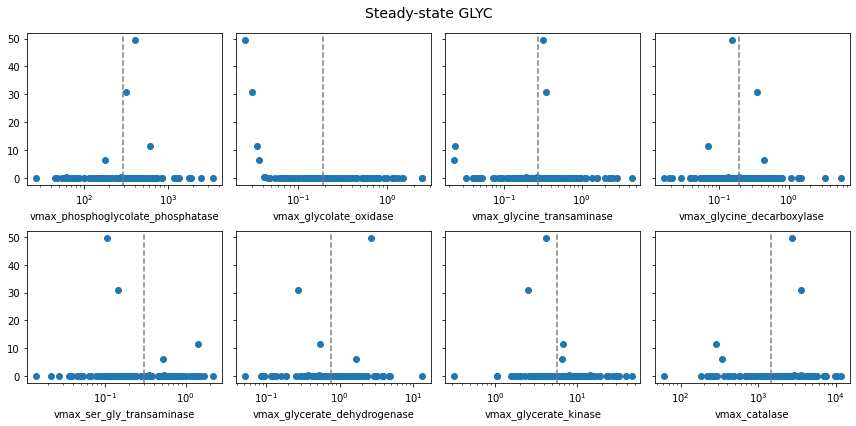

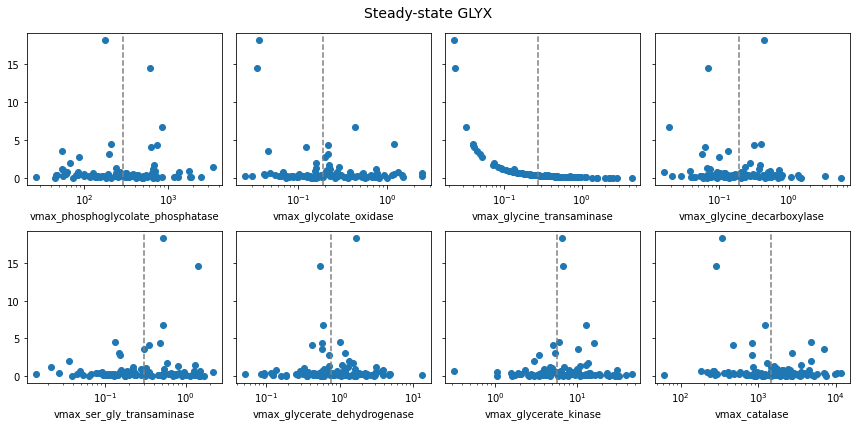

In [12]:
std = cy_rel.describe().loc["std"].sort_values(ascending=False)
print(std[:5])
# ax = c.describe().loc["std"].plot(title="Concentrations std")
for i in std.index[:3]:
    plot_by_enzyme(m, py, cy_rel, i)

CO2_hydration                     2.494303
catalase                          0.927776
glycerate_kinase                  0.195225
glycerate_dehydrogenase           0.195224
serine_glyoxylate_transaminase    0.195222
Name: std, dtype: float64


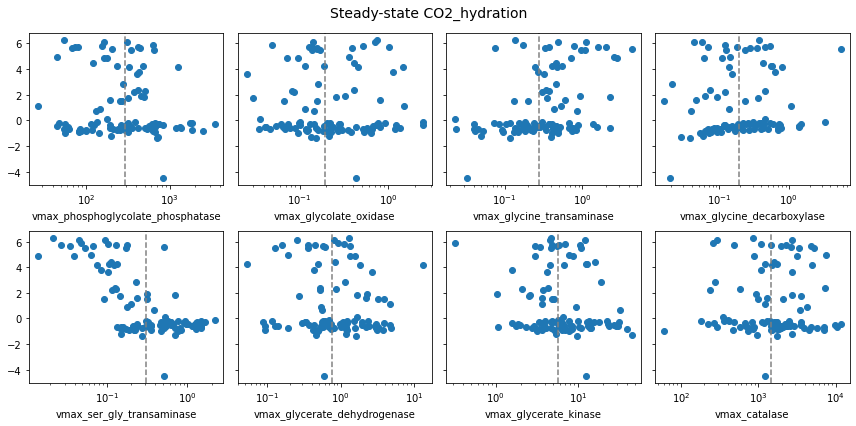

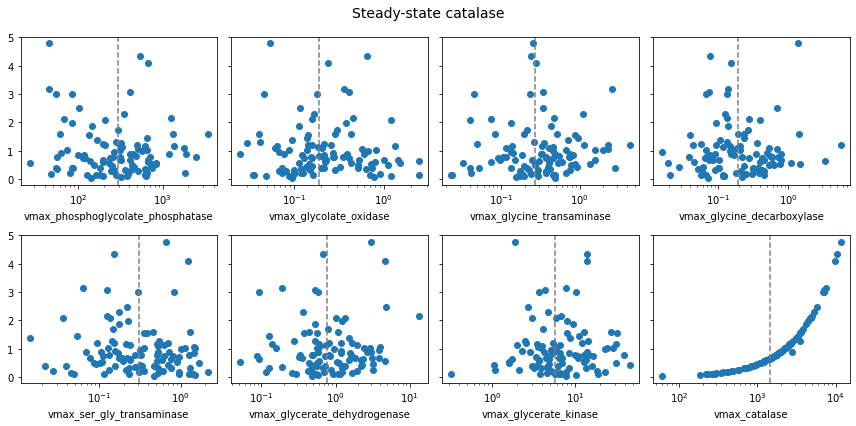

In [13]:
std = vy_rel.describe().loc["std"].sort_values(ascending=False)
print(std[:5])
# ax = std.plot(title="Fluxes std")
for i in std.index[:3]:
    plot_by_enzyme(m, py, vy_rel, i)